In [1]:
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display

import sys
sys.path.append('..')
import helpers, datasets, surfaces, matrices

sns.set_style('ticks')

/home/asaberi/laminar_organization/env/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
samples, laminar_density, laminar_size, laminar_count = datasets.fetch_laminar_cellular_features()

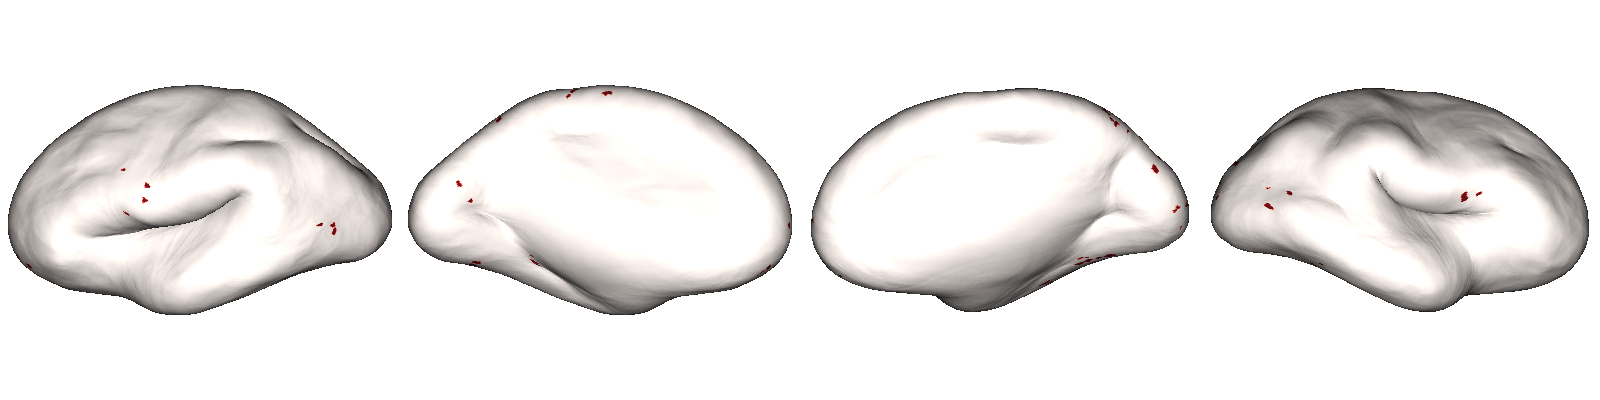

In [3]:
loc = np.zeros(datasets.N_VERTICES_HEM_BB_ICO5 * 2)
loc[samples.index] = 1

helpers.plot_surface(helpers.upsample(loc), cmap='Reds', plot_downsampled=False)

In [4]:
import siibra
atlas = siibra.atlases.MULTILEVEL_HUMAN_ATLAS

v1 = atlas.get_region("v1")
features = siibra.get_features(v1, siibra.modalities.CorticalCellDistribution)
print(f"{len(features)} found for region {v1.name}")

[siibra:INFO] Version: 0.3a26
INFO: Version: 0.3a26
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.
INFO: Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.
[siibra:INFO] No parcellation specified, using default 'Julich-Brain Cytoarchitectonic Maps 2.9'.
INFO: No parcellation specified, using default 'Julich-Brain Cytoarchitectonic Maps 2.9'.
[siibra:WARNING] PREVIEW DATA! CorticalCellDistribution data is only a pre-release snapshot. Contact support@ebrains.eu if you intend to use this data.


10 found for region Area hOc1 (V1, 17, CalcS)


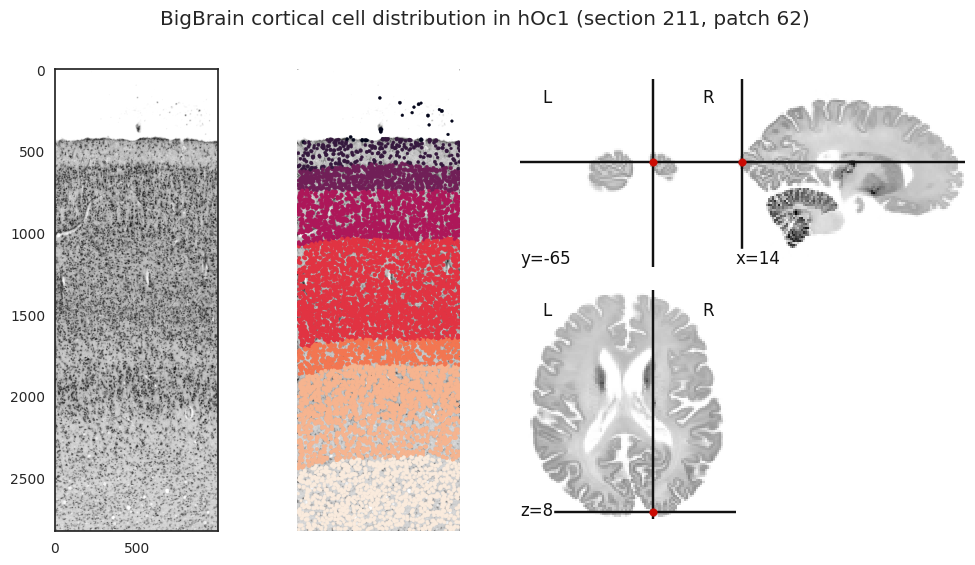

In [5]:
features[0].plot();

In [6]:
ltcg_nonparc = surfaces.MicrostructuralCovarianceGradients(matrices.MicrostructuralCovarianceMatrix('thickness', None))

Loading the matrix from /home/asaberi/laminar_organization/code/../output/ltc/parc-sjh_curv-smooth-10_exc-adysgranular_metric-parcor/matrix.npz
Loading the matrix from /home/asaberi/laminar_organization/code/../output/ltc/parc-sjh_curv-smooth-10_exc-adysgranular_metric-parcor/matrix.npz
Loading the matrix from /home/asaberi/laminar_organization/code/../output/ltc/parc-sjh_curv-smooth-10_exc-adysgranular_metric-parcor/matrix.npz


In [7]:
samples.loc[:, 'LTCG1'] = ltcg_nonparc.surf_data[samples.index, 0]


 Cellular Density


1   -0.053048
2    0.003267
3    0.150707
4    0.537055
5    0.236059
6    0.245079
Name: LTCG1, dtype: float64


 Cellular Size


1   -0.118291
2   -0.163799
3   -0.274991
4   -0.539799
5   -0.374882
6   -0.305341
Name: LTCG1, dtype: float64

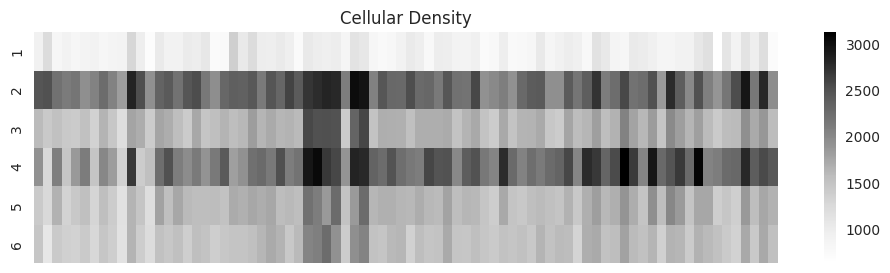

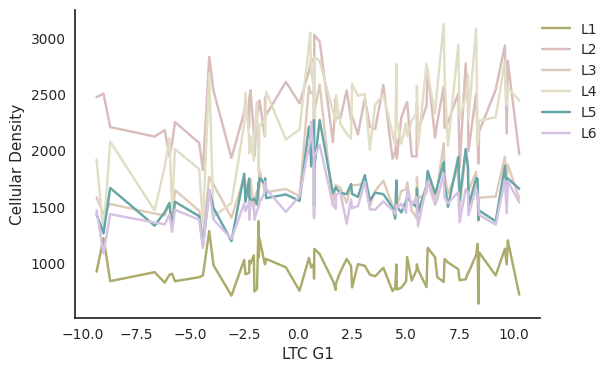

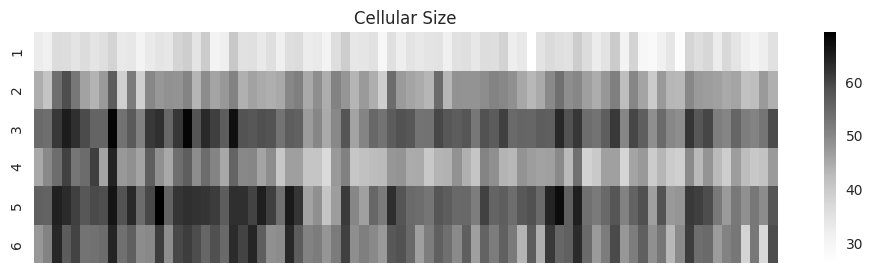

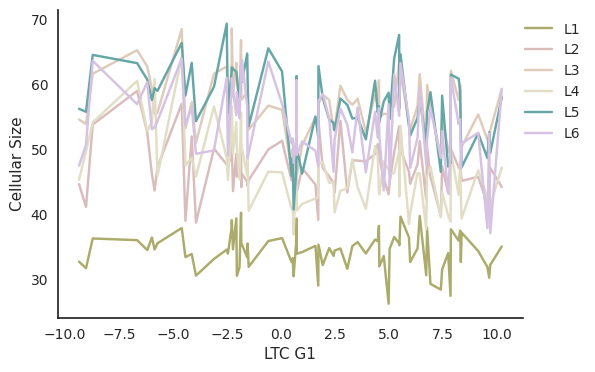

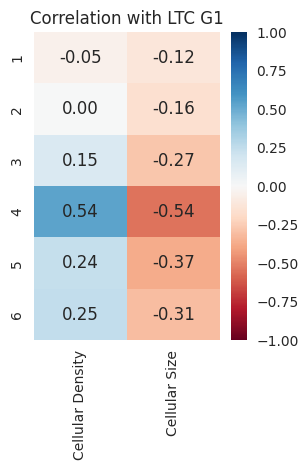

In [8]:
laminar_features = {'cellular density':laminar_density, 'cellular size':laminar_size}
corrs = {}
for name, laminar_feature in laminar_features.items():
    reordered_laminar_feature = laminar_feature.loc[samples.sort_values('LTCG1').index].reset_index(drop=True)
    fig, ax = plt.subplots(1, figsize=(12, 3))
    sns.heatmap(reordered_laminar_feature.T, cmap="Greys", ax=ax)
    ax.set_title(name.title())
    ax.set_xticks([])
    fig, ax = plt.subplots(1, figsize=(6,4))
    for layer in range(1, 7):
        ax.plot(
            samples['LTCG1'].sort_values().values, 
            reordered_laminar_feature.loc[:, str(layer)], 
            color=datasets.LAYERS_COLORS['bigbrain'][layer-1],
        )
    ax.legend([f'L{i}' for i in range(1,7)], bbox_to_anchor=(1.15, 1.0))
    ax.set_xlabel('LTC G1')
    ax.set_ylabel(name.title())
    sns.despine()
    corr = pd.concat([laminar_feature, samples.loc[:, ['LTCG1']]], axis=1).corr().iloc[-1, :-1]
    corrs[name.title()] = corr
    print('\n', name.title())
    display(corr)
    
fig, ax = plt.subplots(1, figsize=(3,4))
ax.set_title('Correlation with LTC G1')
corrs = pd.DataFrame(corrs)
sns.heatmap(corrs, vmin=-1, vmax=1, cmap='RdBu', ax=ax)
for i in range(corrs.shape[0]):
    for j in range(corrs.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{corrs.iloc[i, j]:.2f}', horizontalalignment='center', verticalalignment='center')

In [9]:
expyr = pd.DataFrame({
    'Externopyramidization': laminar_size.loc[:, '3'] / laminar_size.loc[:, '5'],
    'LTC G1': samples['LTCG1']
})

Text(-9.259977580756381, 0.8669152318971772, 'r = 0.27')

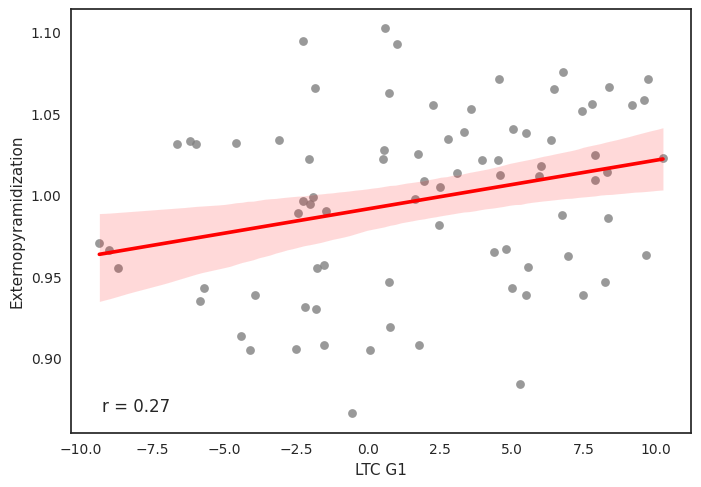

In [10]:
ax = sns.regplot(
    data=expyr, 
    x='LTC G1', y='Externopyramidization',
    scatter_kws=dict(
        s=40, color='grey'),
    line_kws=dict(color='red'),
)
text_x = ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.05
text_y = ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.05
ax.text(
    text_x, text_y, f'r = {expyr.corr().iloc[0, 1]:.2f}'
)